Now that I've figured out morphing DR7 spectra, apply it to the much bigger DR14 sample where it will actually be useful.  Ideally in this notebook the larger training set from DR14 will lead to better reconstruction -- as well as more interpretable "latent parameters".

In [3]:
from tensorflow import keras
#import keras

from astropy.io import fits
from astropy.table import Table
from astropy.io.fits import Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import richardsplot
import os

In [4]:
import tensorflow as tf
np.__version__, tf.__version__, keras.__version__

('1.19.1', '1.12.0', '2.1.6-tf')

In [5]:
#path = "/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/data/"
#path = "/Users/trevormccaffrey/Desktop/Research/GTR/VLA2018b/"
path = "/Volumes/Macintosh HD 1/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/data/"

In [6]:
#Now we're working with dr14 only at 1.627 < z < 2.088, so use this new datafram from hereon
dat = pd.read_csv(path+"DR14_zmin162_zmax208.csv")
dat.head()

Unnamed: 0              SDSS_NAME        RA        DEC   THING_ID  PLATE  \
0          10  b'000001.56+203011.5'  0.006523  20.503197  290594773   7596   
1          19  b'000002.15+151516.6'  0.008980  15.254639  246765254   6172   
2          20  b'000002.19-021947.2'  0.009139  -2.329783   59825899   7850   
3          26  b'000002.97+225645.9'  0.012415  22.946096  311303506   7665   
4          28  b'000003.18+050822.3'  0.013254   5.139552  155964498   8740   

     MJD  FIBERID  SPECTRO         Z  ...         JFLUX     JFLUX_ERR  \
0  56945      821  b'BOSS'  2.083215  ...  0.000000e+00  0.000000e+00   
1  56269      394  b'BOSS'  1.710000  ...  2.910325e-31  4.694344e-32   
2  56956      339  b'BOSS'  1.966623  ...  0.000000e+00  0.000000e+00   
3  57328      452  b'BOSS'  1.759105  ...  0.000000e+00  0.000000e+00   
4  57367      340  b'BOSS'  1.801677  ...  1.431263e-31  4.114480e-32   

          HFLUX     HFLUX_ERR         KFLUX     KFLUX_ERR  FIRST_MATCHED  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             -1   
1  1.572201e-31  5.927228e-32  1.538285e-31  6.478741e-32             -1   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00              0   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00             -1   
4  8.260369e-32  4.348945e-32  2.371781e-31  5.186590e-32              0   

   FIRST_FLUX  FIRST_SNR  SDSS2FIRST_SEP  
0        -1.0       -1.0            -1.0  
1        -1.0       -1.0            -1.0  
2        -1.0       -1.0            -1.0  
3        -1.0       -1.0            -1.0  
4        -1.0       -1.0            -1.0  

[5 rows x 97 columns]

In [7]:
sdss_names = dat[["SDSS_NAME"]].values.flatten()
z     = dat[["Z"]].values.flatten()
plate = dat[["PLATE"]].values.flatten()
mjd   = dat[["MJD"]].values.flatten()
fiber = dat[["FIBERID"]].values.flatten()
BAL   = dat[["BI_CIV"]].values.flatten()!=0

In [8]:
spec_path = path+"CIV_to_MgII/lite/"

In [9]:
#Will want to save homogeneous arrays of each QSO's wavelength, flux, and inverse variance
names   = []
spectra = []
wave    = []
ivar    = []
found   = [] #save dataframe indices which have spectra
BAL_list= []
N = 0

for sdss_name, red, pl, mj, fib, bal in zip(sdss_names, z, plate, mjd, fiber, BAL):
    try:
        hdul_spec = fits.open(spec_path+"%04d/spec-%04d-%05d-%04d.fits" % (pl,pl,mj,fib))
    except FileNotFoundError:
        #print(spec_path+"%04d/spec-%04d-%05d-%04d.fits NOT FOUND" % (pl,pl,mj,fib))
        continue
        
        
    #Load in data from each FITS file
    sdss_flux   = hdul_spec[1].data["flux"]
    sdss_loglam = hdul_spec[1].data["loglam"]
    sdss_wave   = 10.**(sdss_loglam) / (1+red)  #x-axis: wavelength
    sdss_ivar   = hdul_spec[1].data["ivar"]
    
    #Want the same wavelength range for each array
    wavemask   = ((sdss_wave>=1443) & (sdss_wave<=2961))
    sdss_flux  = sdss_flux[wavemask]
    #sdss_flux /= np.median(sdss_flux) #normalize spectrum
    sdss_ivar  = sdss_ivar[wavemask]
    sdss_wave  = sdss_wave[wavemask]
    hdul_spec.close()
    
    if len(sdss_flux) >= 3121:
        names.append(sdss_name)
        spectra.append(sdss_flux[:3121])
        wave.append(sdss_wave[:3121])
        ivar.append(sdss_ivar[:3121])
        found.append(N)
        if bal: BAL_list.append(bal)

    N+=1
    if N%5000==0: print(N)  
    #if N>100: break
    
spectra = np.array(spectra)
wave    = np.array(wave)
ivar    = np.array(ivar)
found = np.array(found)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000


In [10]:
spectra.shape

(91970, 3121)

In [215]:
dat = dat.iloc[found]

----

Now that all spectra are loaded in the desired format, set up the morphing.  See ``autoencoder4_morphing.ipynb`` for how the reference array was obtained.

In [16]:
#Get the normed data
morph_norm = np.load("/Users/Trevor1/Desktop/git/Cosmology_Quasars/morph/morph_ref_DR7mean_normed.npy")
spectra_normed = spectra / np.nanmedian(spectra, axis=1)[:, np.newaxis]
spectra_normed.shape

<ipython-input-16-7db1dcfb9467>:3: RuntimeWarning: invalid value encountered in true_divide
  spectra_normed = spectra / np.nanmedian(spectra, axis=1)[:, np.newaxis]


(91970, 3121)

We'll use this old NN (trained on DR7 spectra) to get reconstructions which will provide the "general shapes" of the spectra which we can then morph; the actual quality of the reconstructions is not much of a concern right now.

In [17]:
#Create the preliminary reconstructions to determine morphing; using reconstructions ignores absorption (mostly)
import tensorflow.keras.backend as K
MASKK= (~((wave[0]>1490)&(wave[0]<1546))).astype(int) #Mask CIV absorption
MASK = K.variable(MASKK)

#Build the autoencoder architecture (keras.models.load_model has all sorts of dependency issues between diff versions of tf)
morph_encoder = keras.models.Sequential([
    keras.layers.Lambda(lambda x: x*MASK, input_shape=[3121]), #this layer is the mask - turn off corresponding neurons
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(6, kernel_initializer="he_normal")
])

morph_decoder = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer="he_normal", input_shape=[6]),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(3121) #no activation function since we want actual pixel values
])

#Load in the training weights from autoencoder3.ipynb
morph_encoder.load_weights("/Users/Trevor1/Desktop/git/Cosmology_Quasars/autoencoders/models/autoencoder3_enc.h5")
morph_decoder.load_weights("/Users/Trevor1/Desktop/git/Cosmology_Quasars/autoencoders/models/autoencoder3_dec.h5")

morph_ae = keras.models.Sequential([morph_encoder, morph_decoder])

spec_norm_reconst_prelim = morph_ae.predict(spectra_normed[:100])

In [18]:
#fit a continuum

markers = {
    1: wave[0][5],
    2: 1690,
    3: 2200,
    4: 2660,
    5: 2915,
    6: wave[0][-5]
}

def continuum(wave, spec, markers):
    #Will do multiple different linear fits on different "regions" of the spectrum
    cont_region = {}
    
    for i in range(len(markers)-1):
        #get left (ind1) and right (ind2) indices of particular region
        ind1 = max( abs(wave-markers[i+1]).argmin(), 5 ) #sometimes this winds up on 4 and yy returns a nan - difference negligibla anyway
        ind2 = abs(wave-markers[i+1+1]).argmin()
        xx = [np.nanmedian(wave[(ind1-5):(ind1+5)]), np.nanmedian(wave[(ind2-5):(ind2+5)])]
        yy = [np.nanmedian(spec[(ind1-5):(ind1+5)]), np.nanmedian(spec[(ind2-5):(ind2+5)])]
        
        #do a linear fit on this region
        fit_region = np.polyfit(xx, yy, 1) 
        
        #if first marker fit on all pixels blueward; elif last all redward; else all in between
        if i==0:
            x = wave[:ind2]
        elif i==(len(markers)-2):
            x = wave[ind1:]
        else:
            x = wave[ind1:ind2]
        
        #Save fit as continuum of given region
        y = fit_region[0]*x + fit_region[1]
        cont_region[i] = [x, y]

    return np.concatenate((cont_region[0][1], cont_region[1][1], cont_region[2][1], cont_region[3][1],
                           cont_region[4][1]))

Make some example plots -- is the morphing working as we expect?

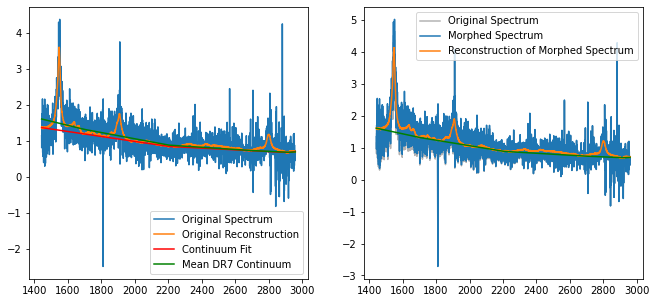

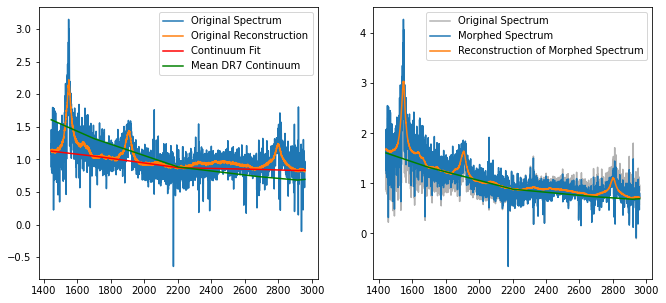

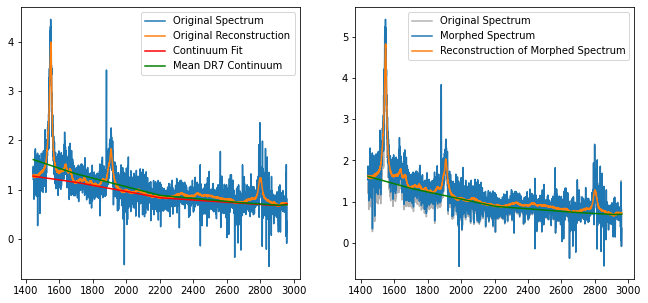

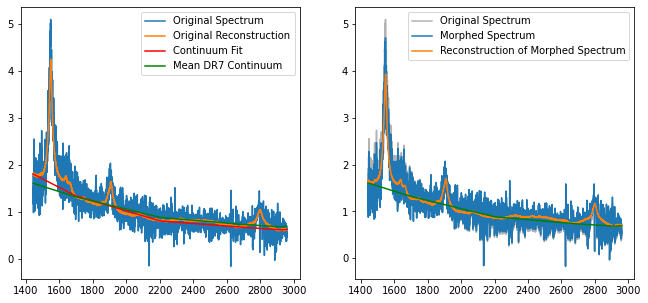

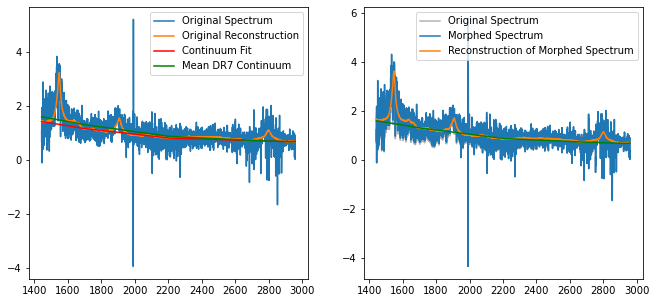

In [19]:
for i in range(5):
    cont = continuum(wave[i], spec_norm_reconst_prelim[i], markers) #get reconstruction-based continuum
    
    #Multiply spectrum by ratio of continuum of unreddened spectrum to that of original spectrum
    morph_coeff = morph_norm / cont 
    spec_morphed = spectra_normed[i] * morph_coeff
    specrec_morphed = morph_ae.predict(np.array([spec_morphed])).flatten()
    
    fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))
    ax1.plot(wave[i], spectra_normed[i], label="Original Spectrum")
    ax1.plot(wave[i], spec_norm_reconst_prelim[i], label="Original Reconstruction")
    ax1.plot(wave[i], cont, "r", label="Continuum Fit")
    ax1.plot(wave[i], morph_norm, "g", label="Mean DR7 Continuum")
    ax1.legend(loc="best")
    
    ax2.plot(wave[i], spectra_normed[i], color="black", alpha=0.3, label="Original Spectrum")
    ax2.plot(wave[i], spec_morphed, label="Morphed Spectrum")
    ax2.plot(wave[i], specrec_morphed, label="Reconstruction of Morphed Spectrum")
    ax2.plot(wave[i], morph_norm, "g")
    ax2.legend(loc="best")
    
    plt.show()

Great, it looks like the morphing is also working well with DR14 spectra.  Now build a new autoencoder based on the morphing, but with a much larger training set.

Reconstruct normed (unmorphed) spectra and load morphed spectra into their own array:

In [20]:
spec_norm_reconst = morph_ae.predict(spectra_normed)

In [21]:
def morph(wave, spectrum, spectrum_reconst, markers):
    cont = continuum(wave, spectrum_reconst, markers) #get reconstruction-based reconstruction
    morph_coeff = morph_norm / cont 
    return spectrum * morph_coeff

spectra_morphed = []

for i in range(len(spectra)):
    spec_morphed = morph(wave[i], spectra_normed[i], spec_norm_reconst[i], markers)
    spectra_morphed.append(spec_morphed)
    
spectra_morphed = np.array(spectra_morphed)

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-21-32c23c73ca8a>:3: RuntimeWarning: divide by zero encountered in true_divide
  morph_coeff = morph_norm / cont


In [22]:
#Get rid of specs full of nans
allnan = np.nanmedian(spectra_morphed, axis=1)
print(np.isnan(allnan).sum())

#Can't use spec with inf anywhere - loss will explode
no_inf = []
for i in range(len(spectra_morphed)):
    if not np.isinf(spectra_morphed[i]).any():
        no_inf.append(True)
    else:
        no_inf.append(False)
no_inf = np.array(no_inf)

#only work with valid spectra
valid = ( (~np.isnan(allnan)) & (no_inf) )
spectra_morphed = spectra_morphed[valid]

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


7


In [249]:
dat = dat[valid]

In [23]:
import tensorflow.keras.backend as K

In [254]:
#Mask CIV absorption
n_latent = 4
MASKK= (~((wave[0]>1480)&(wave[0]<1549))).astype(int) #Mask CIV absorption - might want to shorten red end
MASK = K.variable(MASKK)

In [284]:
#Build the encoder - the dimension of the final layer is the dimension of the latent space
stacked_encoder = keras.models.Sequential([
    keras.layers.Lambda(lambda x: x*MASK, input_shape=spectra[0].shape), #this layer is the mask - turn off corresponding neurons
    keras.layers.PReLU(), #using parametric leaky ReLU
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(50, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(n_latent, kernel_initializer="he_normal")
])

#Build the decoder - given values in latent space, it will reconstruct the original spectrum
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(50, kernel_initializer="he_normal", input_shape=[n_latent]),
    keras.layers.PReLU(),
    keras.layers.Dense(200, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(spectra[0].shape[0]) 
])

#Now put them together
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

Now need to compile our model.  The two main ingredients will be the loss function we choose, and the optimizer.  Keep it simple for now, and just see what happens with mean square error and stochastic gradient descent.

In [337]:
stacked_ae.compile(loss="logcosh", optimizer=keras.optimizers.Nadam(lr=1e-5, beta_1=0.9, beta_2=0.999))

In [313]:
#Training data will have equal # of quasars in each CIV distance bin
df_train = pd.read_csv("/Users/Trevor1/Desktop/data/files/catalogs/dr14_train_uniform.csv")
df_valid = pd.read_csv("/Users/Trevor1/Desktop/data/files/catalogs/dr14_valid_uniform.csv")

In [314]:
dat.shape, df_train.shape, df_valid.shape

((91962, 97), (20000, 64), (7500, 64))

In [315]:
#Both from Amy's file, so can match indices by name
train = []
valid = []
for i in range(len(dat)):
    if names[i] in df_train["SDSS_NAME"].values:
        train.append(True)
        valid.append(False)
    elif names[i] in df_valid["SDSS_NAME"].values:
        valid.append(True)
        train.append(False)
    else:
        train.append(False)
        valid.append(False)
        
train = np.array(train)
valid = np.array(valid)
train.sum(), valid.sum()

(19593, 7233)

Fine.

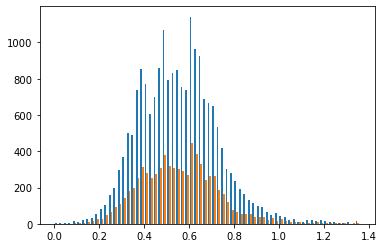

In [316]:
_ = plt.hist([df_train["CIV_Distance"], df_valid["CIV_Distance"]], bins="scott")

In [317]:
spectra_morphed.shape, train.shape

((91962, 3121), (91962,))

In [318]:
X_train = spectra_morphed[train]
X_valid = spectra_morphed[valid]
X_test  = spectra_morphed[((~train)&(~valid))][:7000]

In [338]:
#X_train = spectra_morphed[:65000]
#X_valid = spectra_morphed[65000:77500]
#X_test  = spectra_morphed[77500:]

#X_train will be both the "input" (to the encoder) and the "target" (of the decoder) for the autoencoder
history = stacked_ae.fit(X_train, X_train, epochs=8,
                         validation_data=(X_valid, X_valid))

Train on 19593 samples, validate on 7233 samples
Epoch 1/8
19593/19593 [==============================] - 15s 758us/step - loss: 0.0810 - val_loss: 0.0800
Epoch 2/8
19593/19593 [==============================] - 13s 649us/step - loss: 0.0810 - val_loss: 0.0800
Epoch 3/8
19593/19593 [==============================] - 12s 624us/step - loss: 0.0810 - val_loss: 0.0801
Epoch 4/8
19593/19593 [==============================] - 12s 632us/step - loss: 0.0810 - val_loss: 0.0800
Epoch 5/8
19593/19593 [==============================] - 12s 631us/step - loss: 0.0810 - val_loss: 0.0801
Epoch 6/8
19593/19593 [==============================] - 13s 660us/step - loss: 0.0810 - val_loss: 0.0801
Epoch 7/8
19593/19593 [==============================] - 13s 672us/step - loss: 0.0810 - val_loss: 0.0801
Epoch 8/8
19593/19593 [==============================] - 13s 673us/step - loss: 0.0810 - val_loss: 0.0801


Note: This wasn't the only round of training.  Want to start with higher learning rate then slowly decrease.

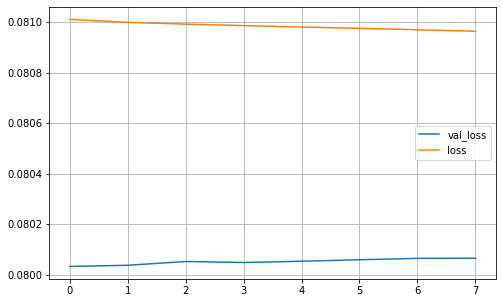

In [339]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [340]:
reconst = stacked_ae.predict(np.array([X_test[0]]))

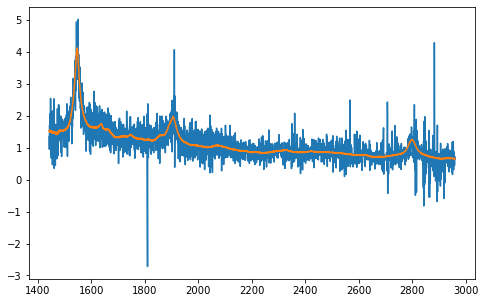

In [341]:
fig = plt.figure(figsize=(8,5))

#plt.plot(wave[800], spectra[800])
plt.plot(wave[6000], X_test[0])
plt.plot(wave[6000], reconst[0])
plt.show()

In [342]:
n_spectra = 100
reconst = stacked_ae.predict(np.array(X_test[:n_spectra]))

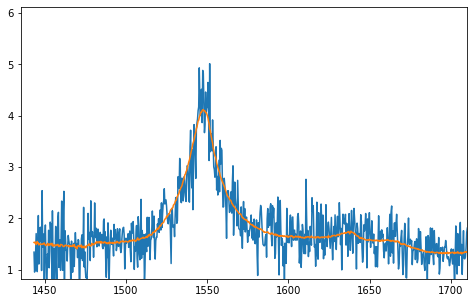

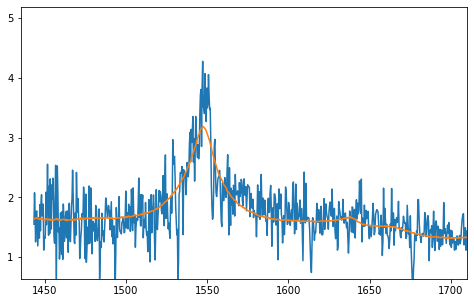

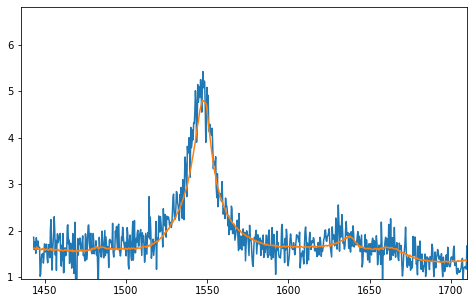

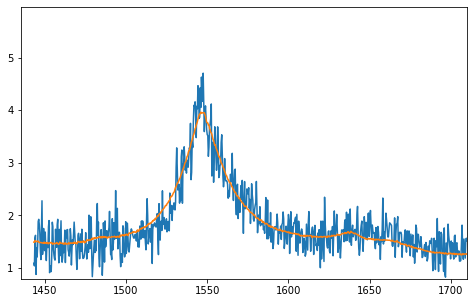

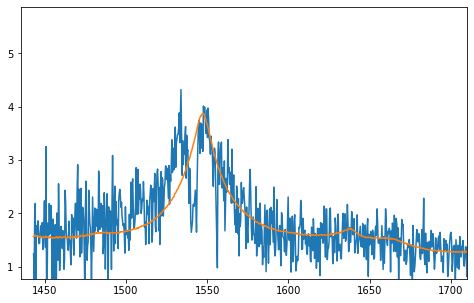

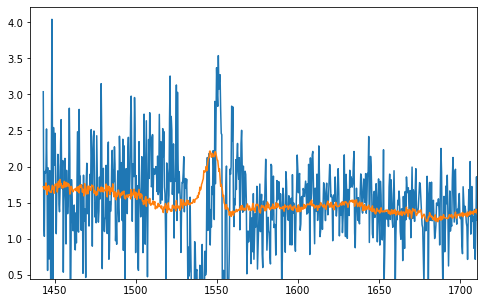

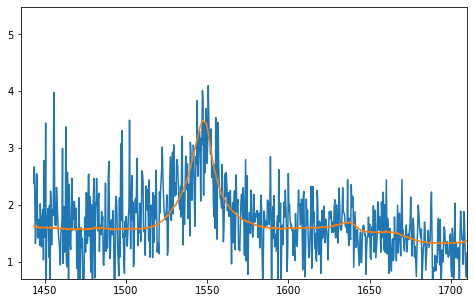

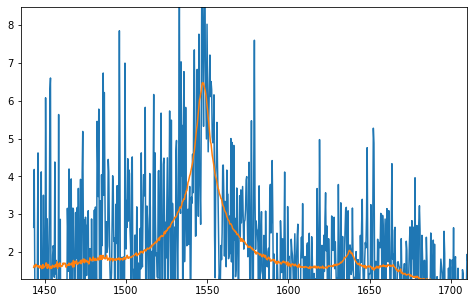

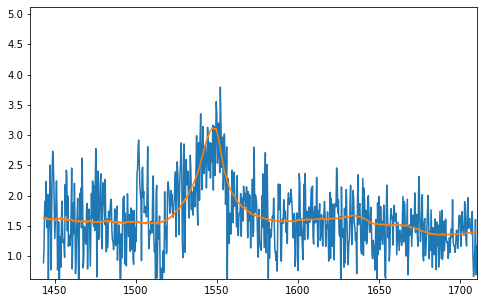

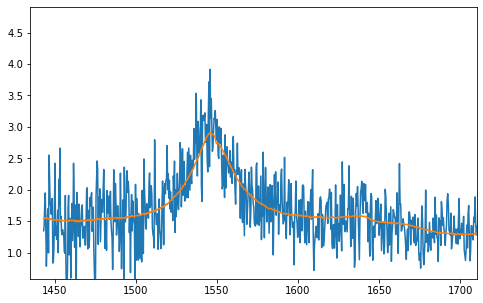

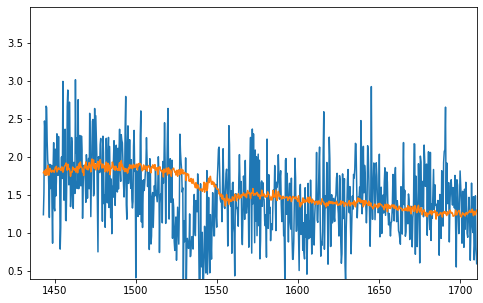

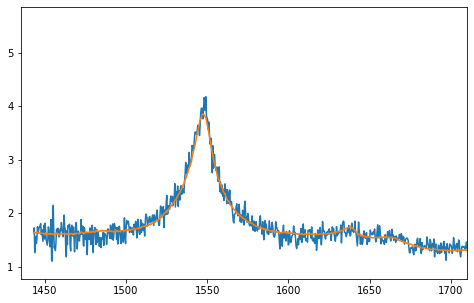

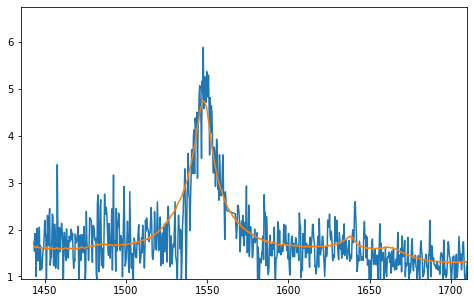

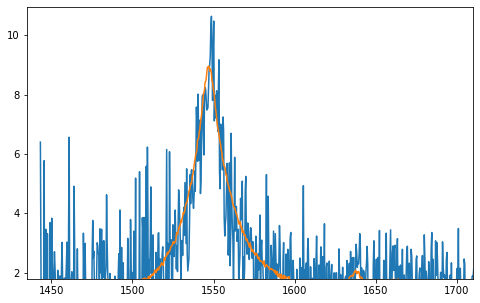

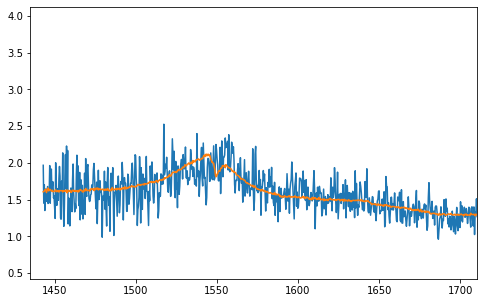

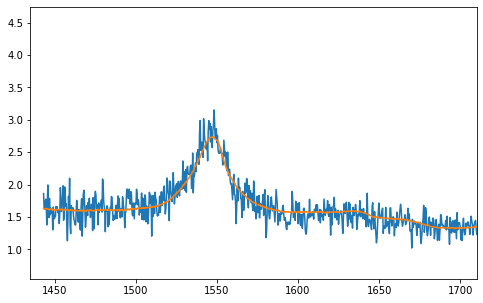

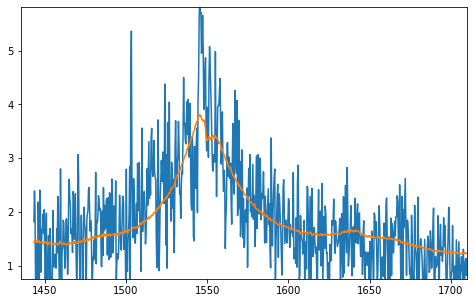

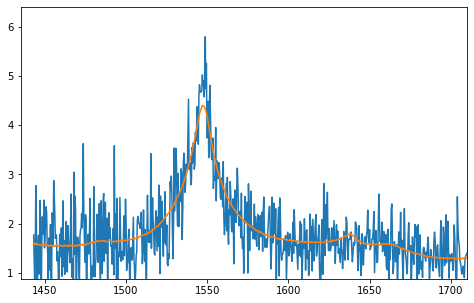

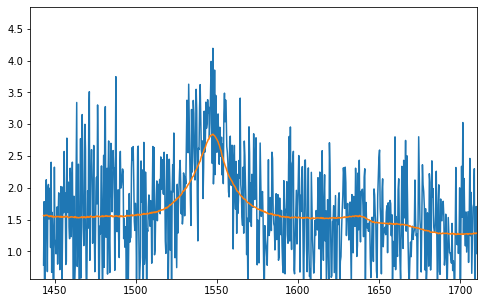

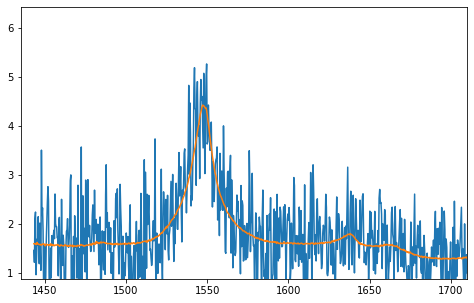

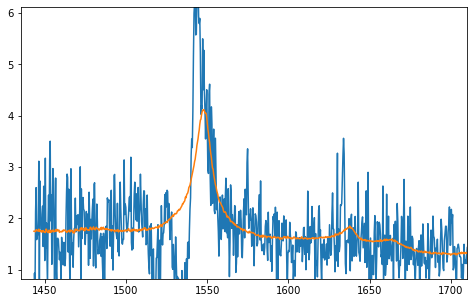

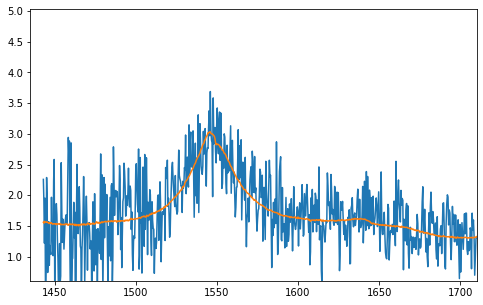

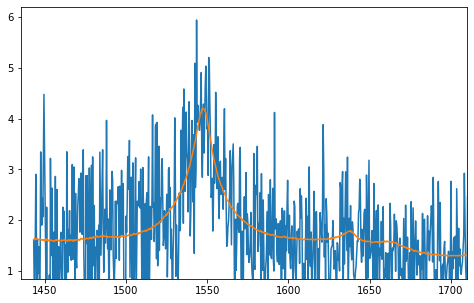

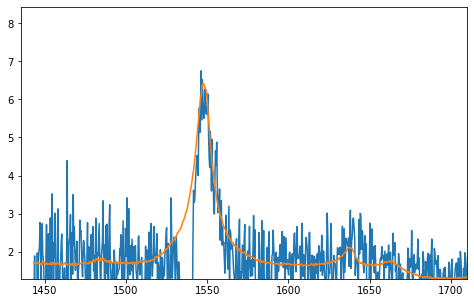

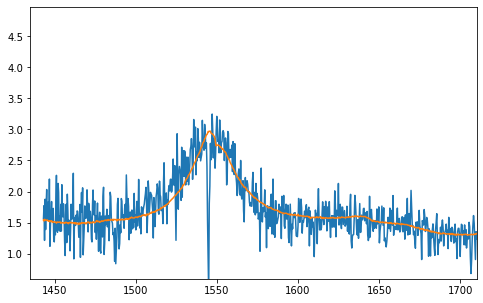

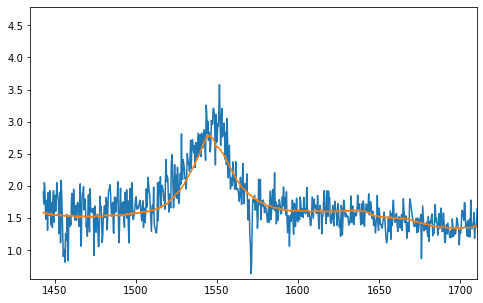

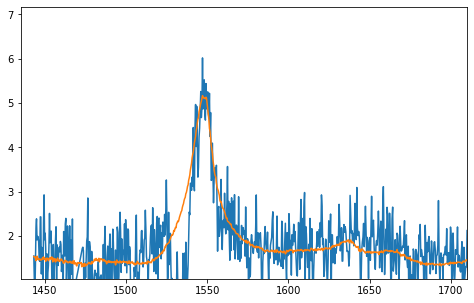

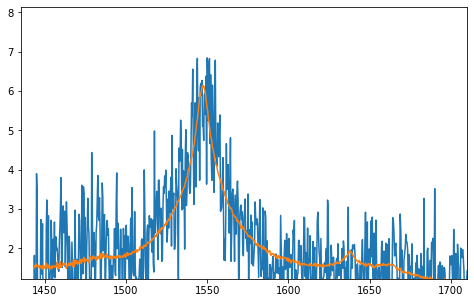

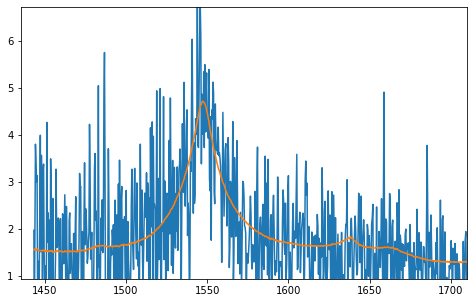

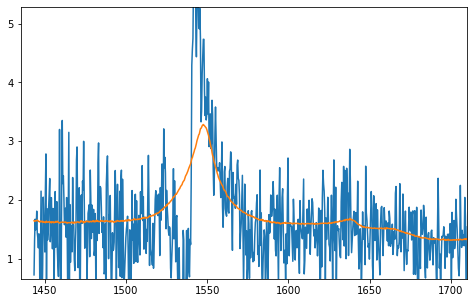

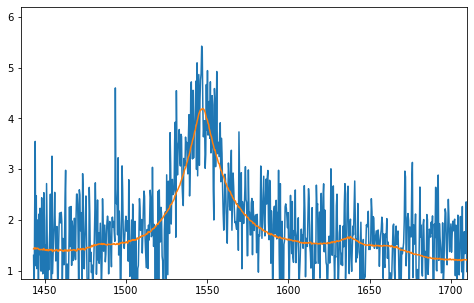

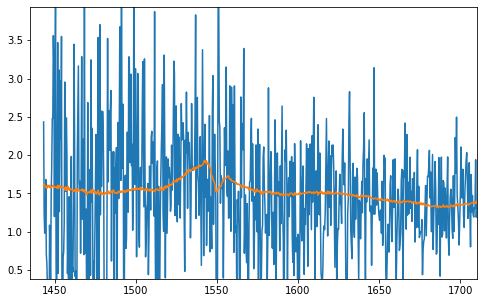

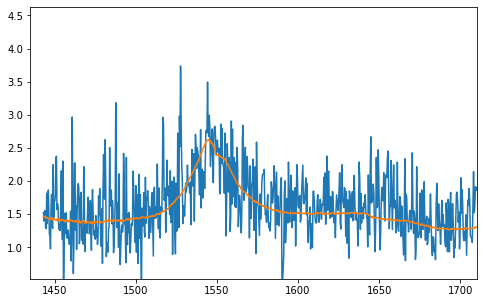

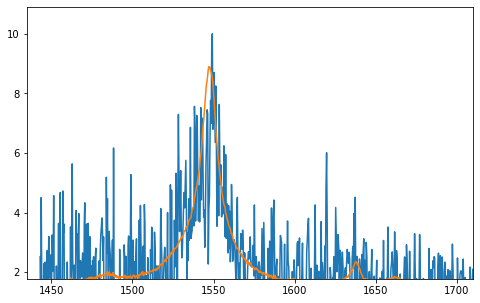

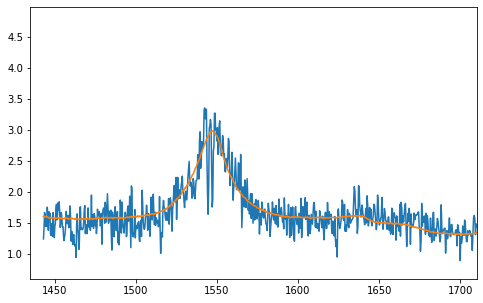

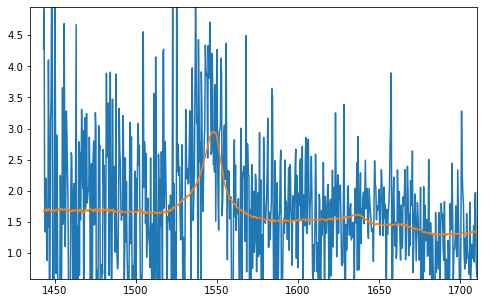

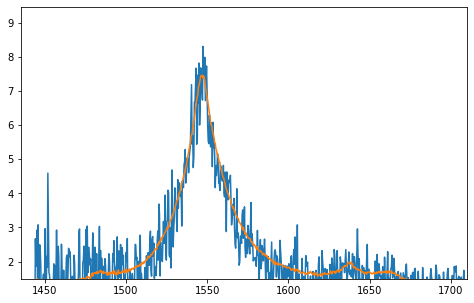

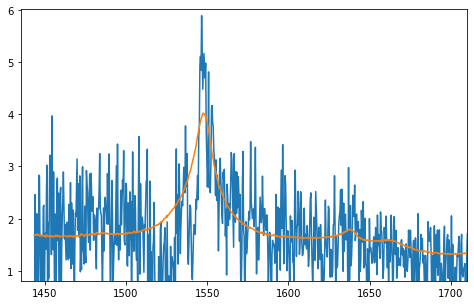

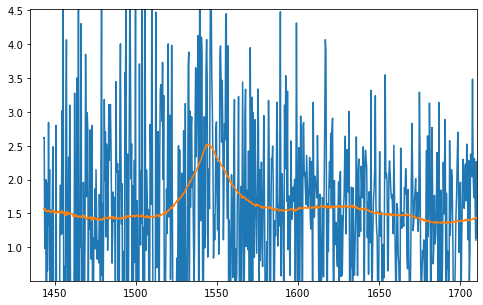

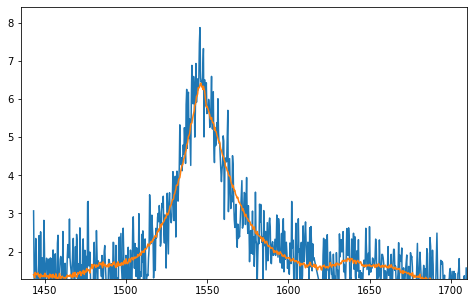

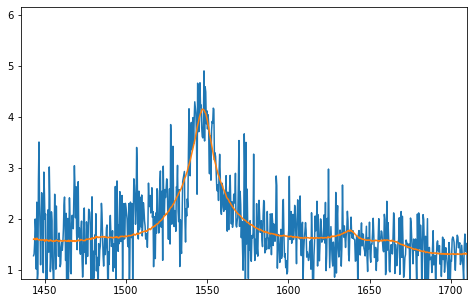

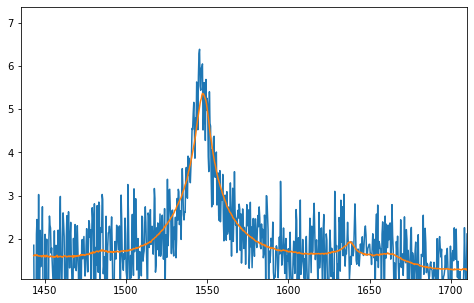

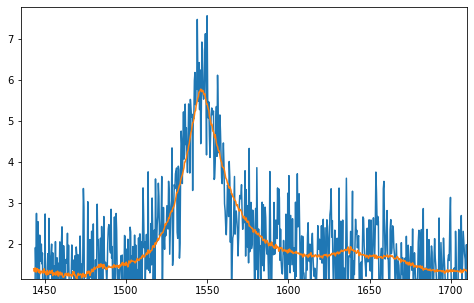

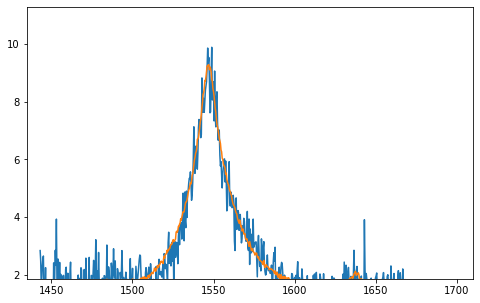

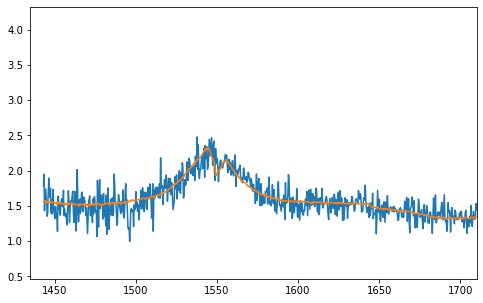

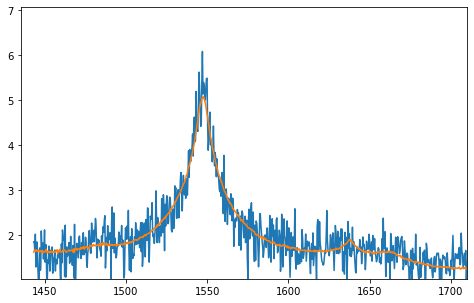

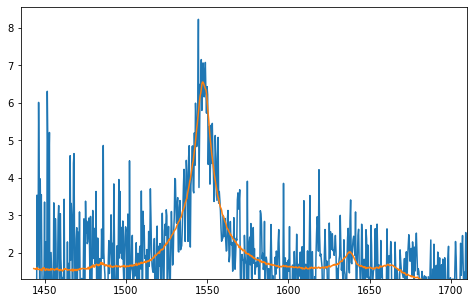

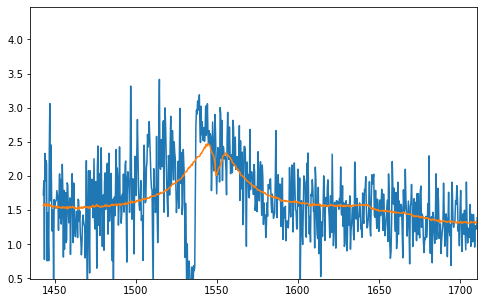

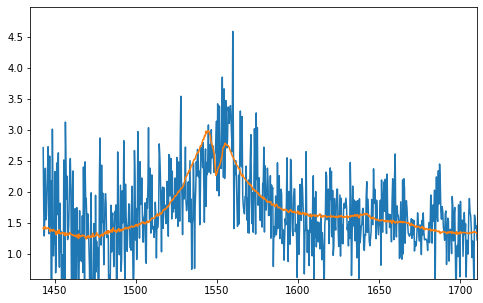

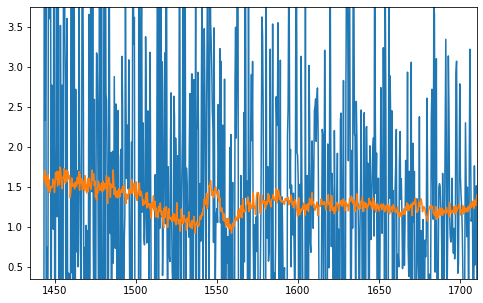

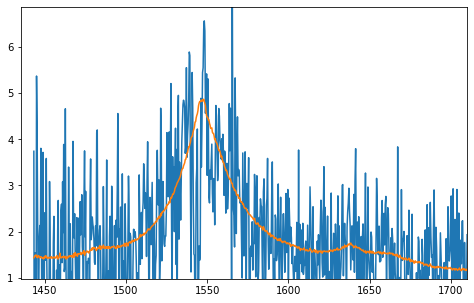

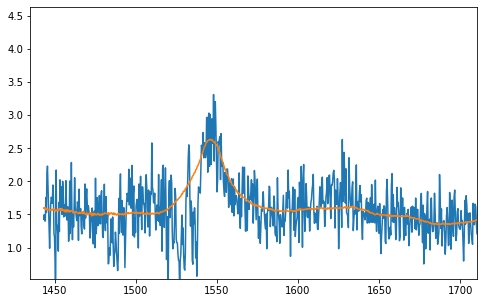

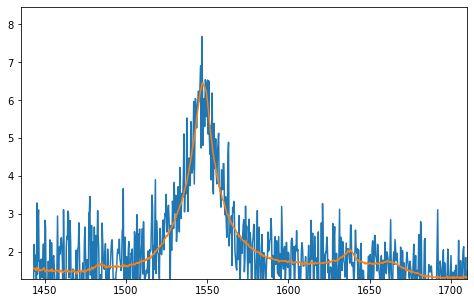

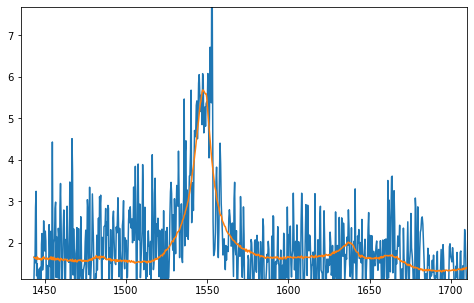

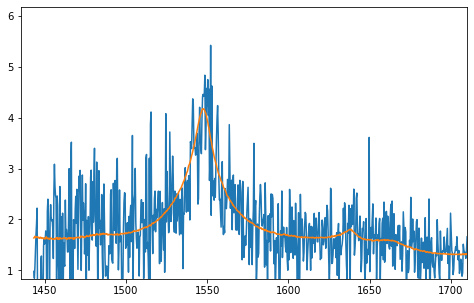

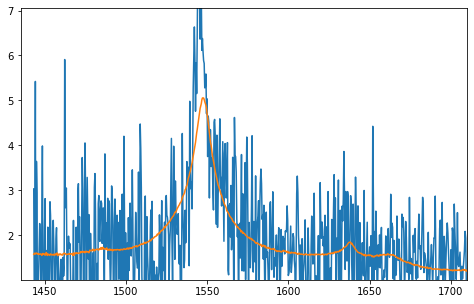

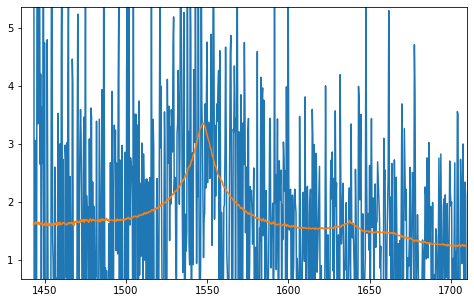

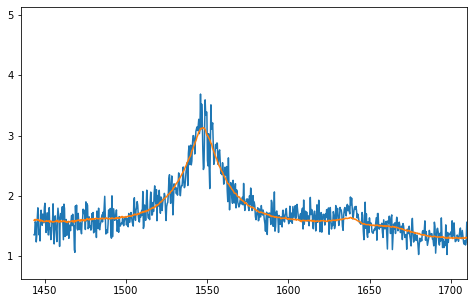

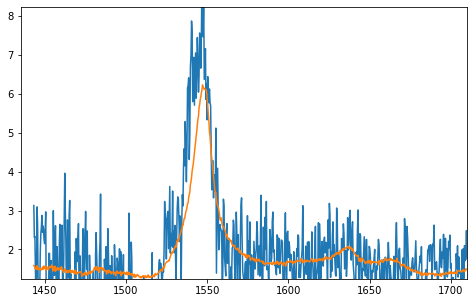

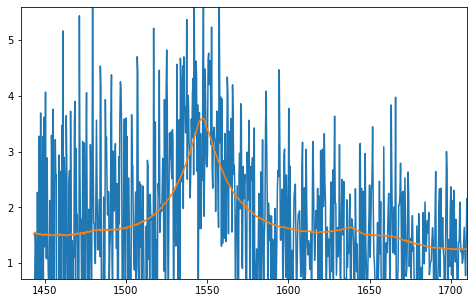

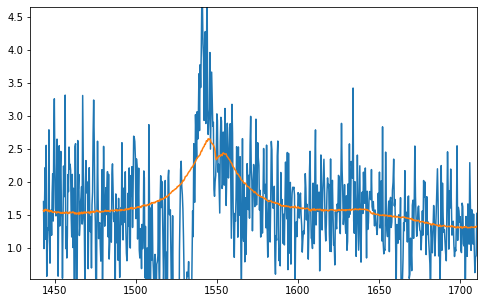

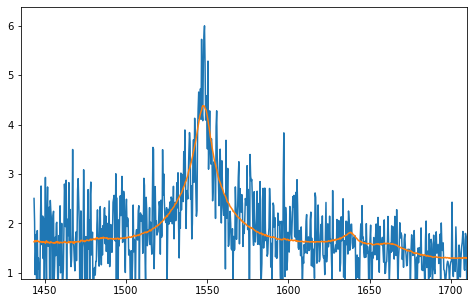

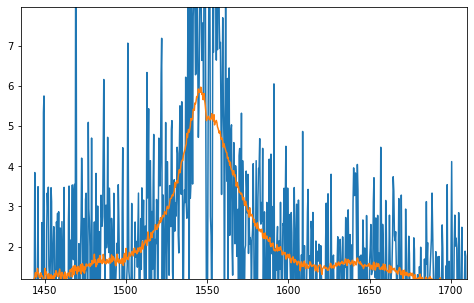

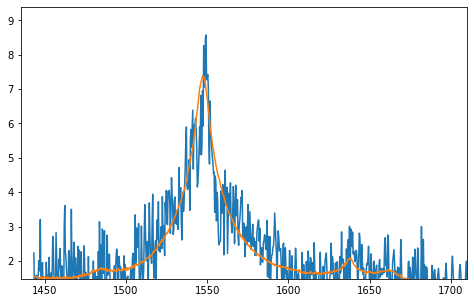

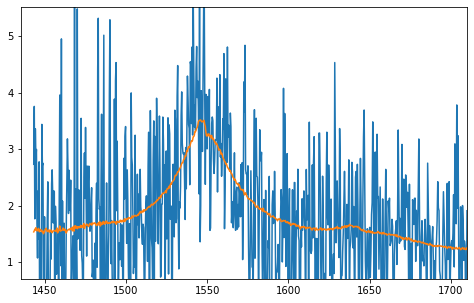

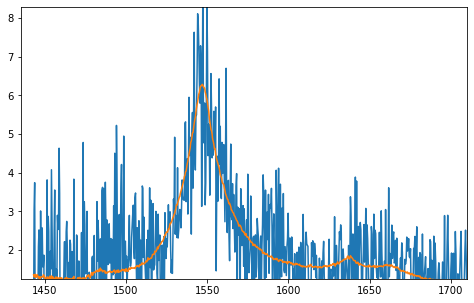

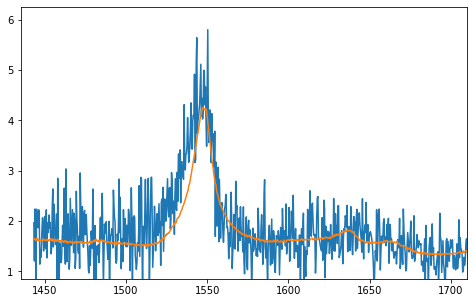

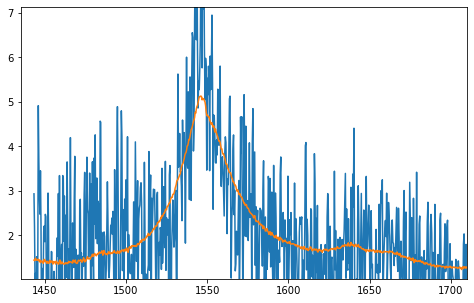

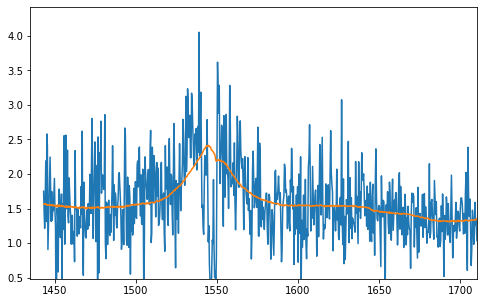

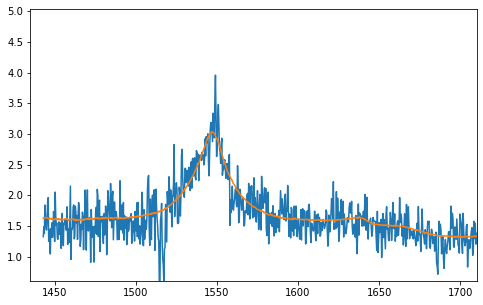

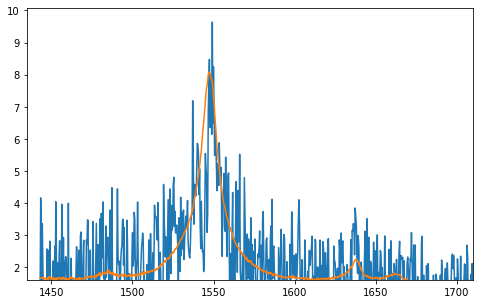

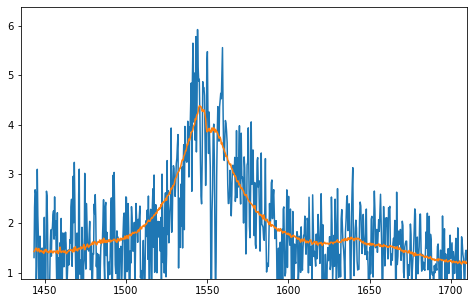

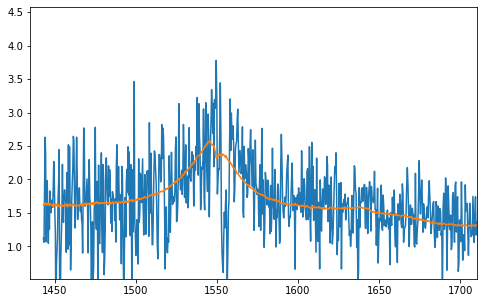

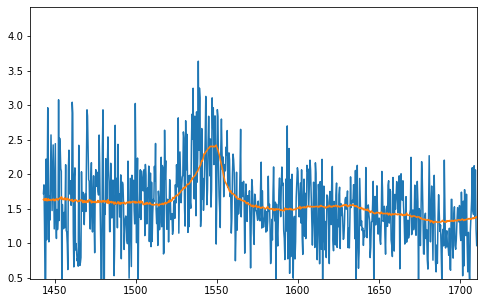

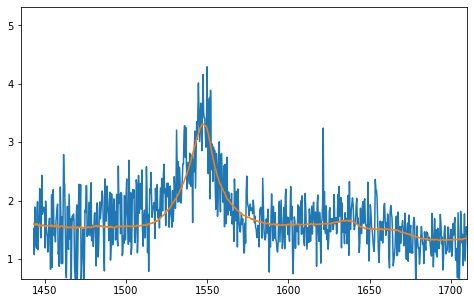

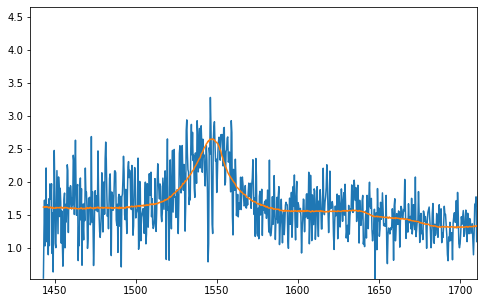

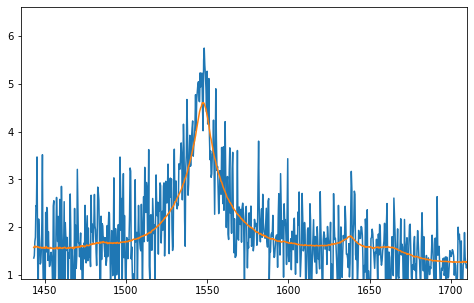

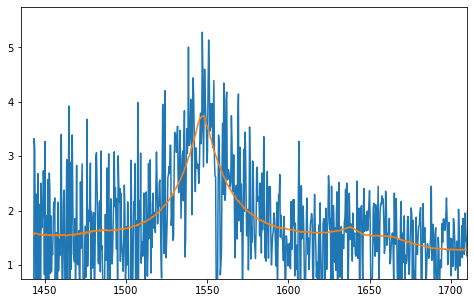

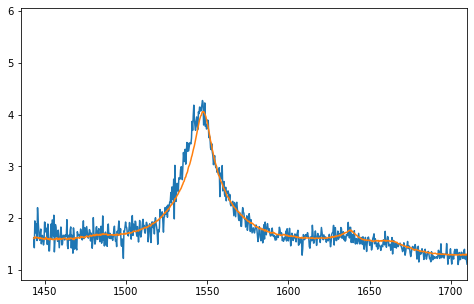

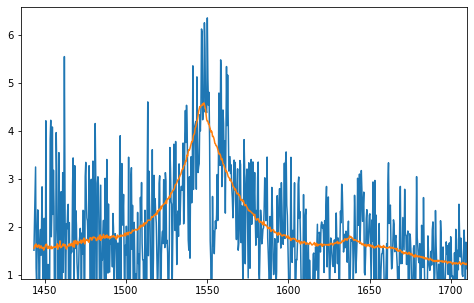

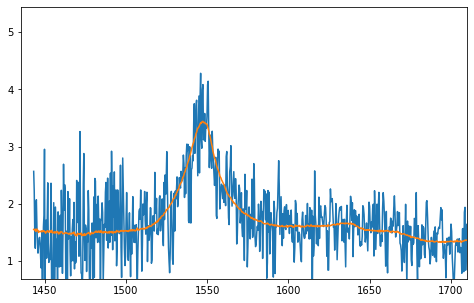

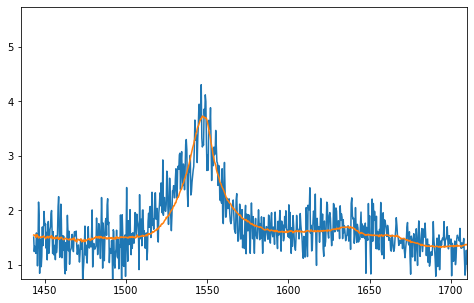

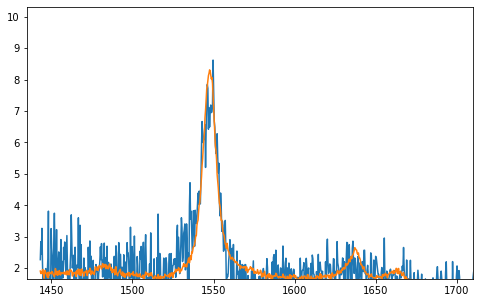

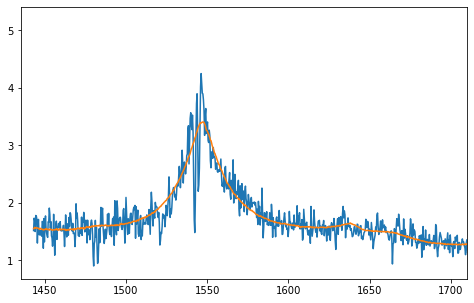

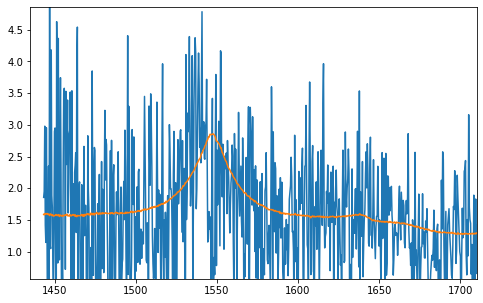

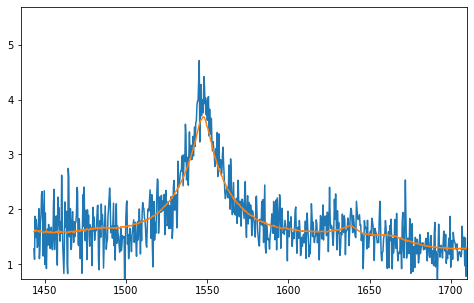

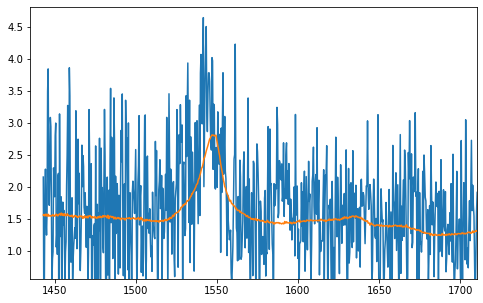

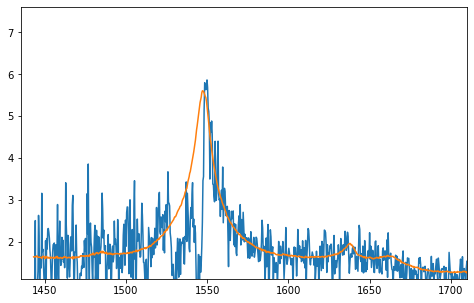

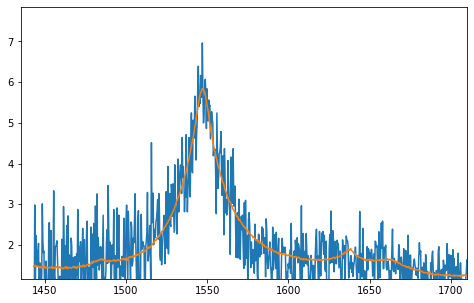

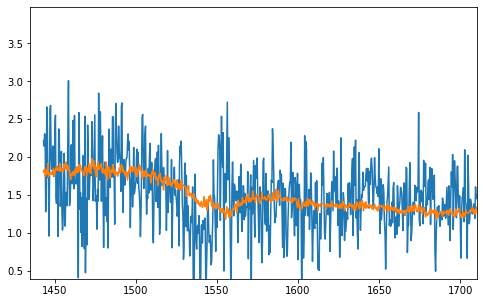

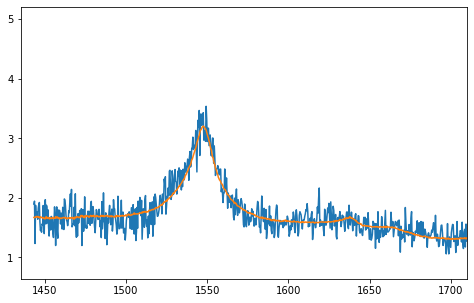

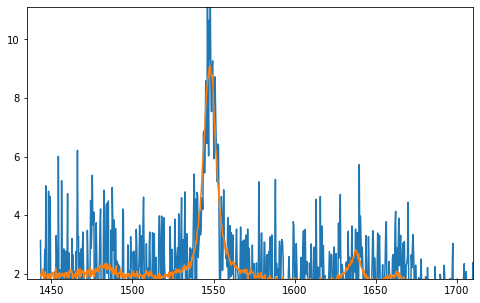

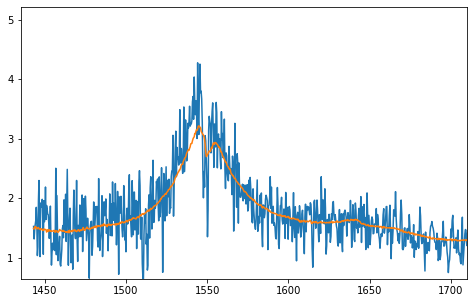

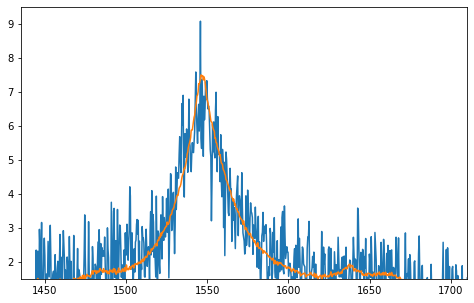

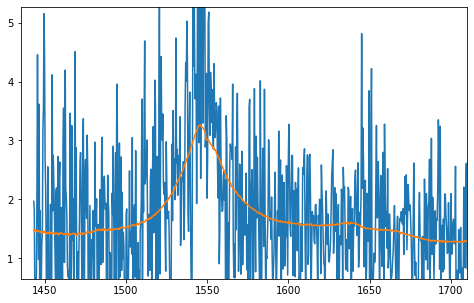

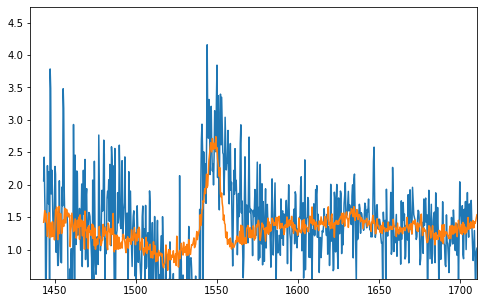

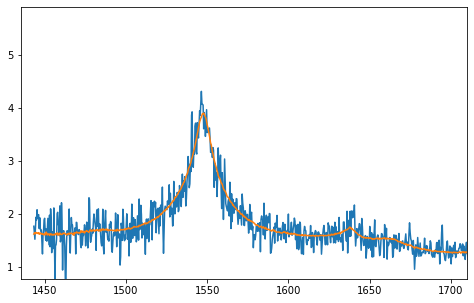

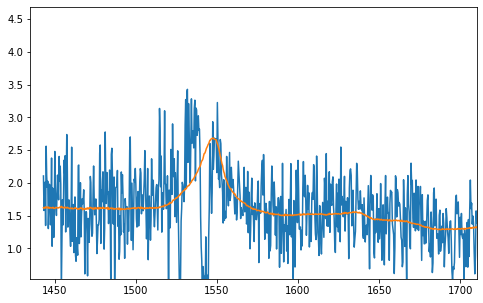

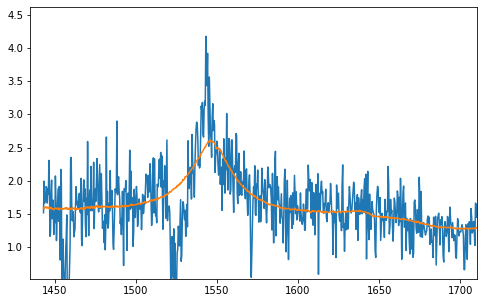

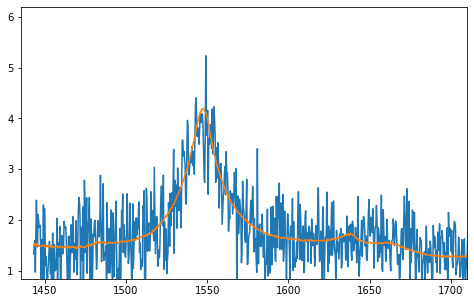

In [350]:
for i in range(n_spectra):
    #reconst = stacked_ae.predict(np.array([X_valid[i]]))
    fig = plt.figure(figsize=(8,5))
    plt.plot(wave[6000+i], X_test[i])
    plt.plot(wave[6000+i], reconst[i])
    plt.xlim(1435, 1710)
    plt.ylim(0.2*max(reconst[i]), max(reconst[i])+2)
    plt.show()

Generally pretty good, but definitely weak in some areas.  Stronger emission lines (CIII] and MgII) it seems to struggle with; odd that it seems to sometimes get those spectra right though.  Maybe move to DR14 and get some more spectra now; hopefully more training data will help with some issues.

``Adam`` is definitely the optimizer to use.

In [344]:
X = np.vstack([X_train, X_valid, X_test])
X.shape

(33826, 3121)

In [345]:
#Compress the spectra down to N dimensions
X_compressed = stacked_encoder.predict(X)

In [346]:
X_compressed.shape

(33826, 4)

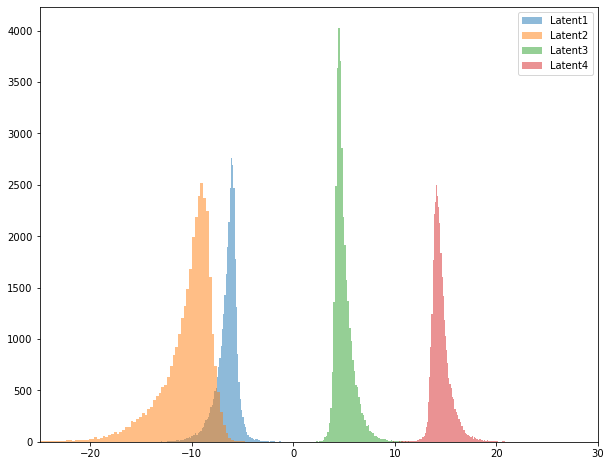

In [347]:
fig = plt.figure(figsize=(10,8))
for i in range(X_compressed.shape[1]):
    _ = plt.hist(X_compressed[:,i],bins='scott', alpha=0.5, label="Latent{}".format(i+1))
plt.legend(loc="best")
plt.xlim(-25, 30)
plt.show()

Note: The SeLU activation function leads to saturation at ~-1.75 for four of the latent parameters; use leaky ReLU to get nice distributions like above.

In [348]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)#,learning_rate=150)
projTSNE2 = tsne.fit_transform(X_compressed)

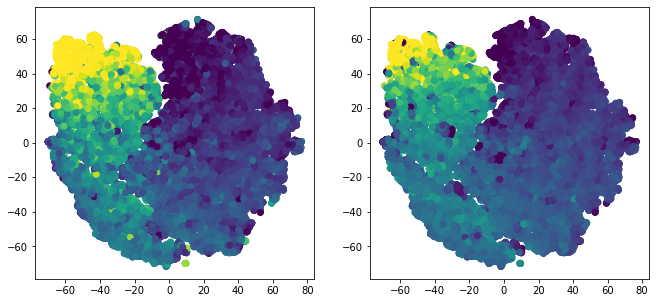

In [349]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11,5))
ax1.scatter(projTSNE2[:,0], projTSNE2[:,1], c=X_compressed[:,2], vmin=np.percentile(X_compressed[:,2], 5), vmax=np.percentile(X_compressed[:,2], 95))
ax2.scatter(projTSNE2[:,0], projTSNE2[:,1], c=X_compressed[:,3], vmin=np.percentile(X_compressed[:,3], 2), vmax=np.percentile(X_compressed[:,3], 98))
plt.show()


Now want to see what exactly each latent parameter represents.  Since we're dealing with 10 parameters, the space created by them is essentially a 10-dimensional hypersphere.  We can track the change caused by one parameter by holding the rest constant (at their median), and changing the value of the given latent parameter incrementally.  Then, after the increment, feed the latent parameters to the decoder and see what information it holds.


In [82]:
X_compressed

array([[  4.708898 ,  20.525629 , -20.916336 ,  16.021116 ],
       [  5.805786 ,  20.70718  , -20.899555 ,  15.3210335],
       [  4.528025 ,  22.345528 , -21.907349 ,  16.386497 ],
       ...,
       [  4.1814394,  22.218027 , -22.094328 ,  16.079119 ],
       [  5.141551 ,  21.69765  , -21.132315 ,  15.825939 ],
       [  5.7272224,  20.471716 , -20.176704 ,  15.275553 ]],
      dtype=float32)

In [83]:
np.median(X_compressed, axis=0)

array([  5.1068945,  20.674728 , -20.687141 ,  15.5072   ], dtype=float32)

In [84]:
def blueshift(wave_half_flux):
    return ((1549.48 - wave_half_flux) / 1549.48) * 3e5

CIV EW = 37.70 Å, CIV Blueshift = 269.03 km/s


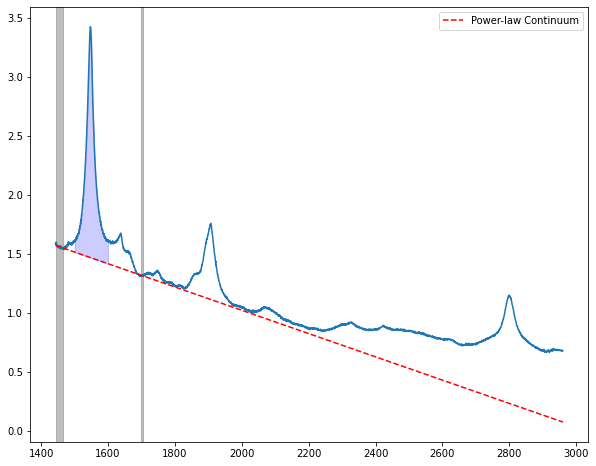

In [351]:
test = stacked_decoder.predict(np.array([np.median(X_compressed, axis=0)]))
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(wave[0], test[0])
#ax.plot([1549.48,1549.48], [10, 27], "--k", label="Laboratory Wavelength - CIV")
#plt.xscale("log")

#Find the blueshift
CIV = (wave[0]>1465)&(wave[0]<1650)
civ_peak = wave[0][CIV][test[0][CIV].argmax()]
#ax.plot([civ_peak,civ_peak], [10, 27], "--", label="Measured Wavelength - CIV")
#print(((1549.48-civ_peak)/1549.48)*3e5, "km/s")


#Fit continuum
cont1 = ((wave[0]>=1445)&(wave[0]<=1465))
cont2 = ((wave[0]>=1700)&(wave[0]<=1705))
ax.axvspan(1445, 1465, alpha=0.5, color='grey')
ax.axvspan(1700, 1705, alpha=0.5, color='grey')


m,b = np.polyfit(np.concatenate((wave[0][cont1], wave[0][cont2])), np.concatenate((test[0][cont1], test[0][cont2])), 1)
continuum = wave[0]*m + b
plt.plot(wave[0], continuum, "--r", label="Power-law Continuum")\

#Plot EW to compute
EW = ((wave[0]>=1500)&(wave[0]<=1600))
ax.fill_between(wave[0][EW], 
                continuum[EW],
                test[0][EW], color="blue", alpha=0.2)

#And compute the EW
CIV_EW = 0
ew_list = [0.]
for i in range(len(wave[0][EW])):
    try:
        CIV_EW += ( (test[0][EW][i] - continuum[i]) / continuum[i] ) * ( wave[0][EW][i+1] - wave[0][EW][i] )
    except IndexError:
        CIV_EW += ( (test[0][EW][i] - continuum[i]) / continuum[i] ) * ( wave[0][EW][i] - wave[0][EW][i-1] )
        
    ew_list.append(CIV_EW)
        
        
ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()

print("CIV EW = %.2f Å, CIV Blueshift = %.2f km/s" % (CIV_EW, blueshift(wave[0][EW][ind_half_flux])))

plt.legend(loc="best")
plt.show()

In [352]:
def get_latent(X_comp, n, n_versions):
    #remove comments to plot - but this causes problems since noisy spectra are at extrema,
    #so just return spectra and choose which to plot
    
    #fig = plt.figure(figsize=(12,10))
    
    predictions = np.array([])
    
    #Set bounds to traverse when plotting differences
    low, high = np.percentile(X_comp[:,n], [1, 99])
    
    #get the median for all other values
    median = np.median(X_comp, axis=0)
    #median_other = np.delete(X_comp, n)
    
    #loop through min-->max and get corresponding spectra
    for i in np.linspace(low, high, n_versions): #maybe sample from logspace here instead?
        latent_params = median.copy()
        latent_params[n] = i
        predict = stacked_decoder.predict(np.array([latent_params]))
        
        if len(predictions) > 0:
            predictions = np.vstack([predictions, predict])
        else:
            predictions = np.append(predictions, predict)
        
        #plt.plot(wave[0], predict[0], alpha=0.6)
        
        
    #plt.show()
    
    return predictions

In [353]:
n_diff = 4
prediction = np.array([[]])

predict1 = get_latent(X_compressed, 0, n_diff)
predict2 = get_latent(X_compressed, 1, n_diff)
predict3 = get_latent(X_compressed, 2, n_diff)
predict4 = get_latent(X_compressed, 3, n_diff)
#predict5 = get_latent(X_compressed, 4, n_diff)
#predict6 = get_latent(X_compressed, 5, n_diff)
#predict7 = get_latent(X_compressed, 6, n_diff)
#predict8 = get_latent(X_compressed, 7, n_diff)
#predict9 = get_latent(X_compressed, 8, n_diff)
#predict10= get_latent(X_compressed, 9, n_diff)

In [354]:
predict1[0]

array([1.37394369, 1.35397446, 1.39943957, ..., 0.65558898, 0.69499856,
       0.65279925])

In [355]:
def plot_latent(prediction, omit=0, reverse=True, CIVonly=False):
    fig = plt.figure(figsize=(12,10))
    if reverse:
        for i in range(prediction.shape[0]-1-omit, -1, -1):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    else:
        for i in range(prediction.shape[0]-omit):
            plt.plot(wave[0], prediction[i], label="Inc{}".format(i+1))
    if CIVonly:
        plt.xlim(1450, 1700)
    plt.legend(loc="best")
    plt.show()

#### Param1

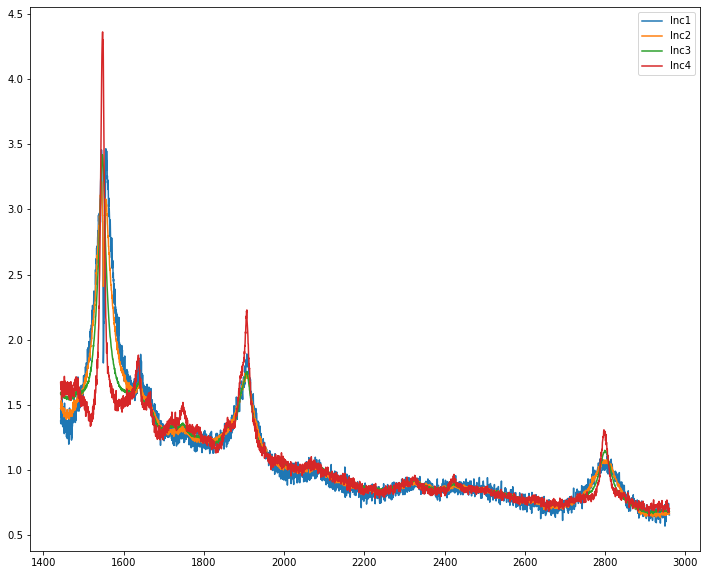

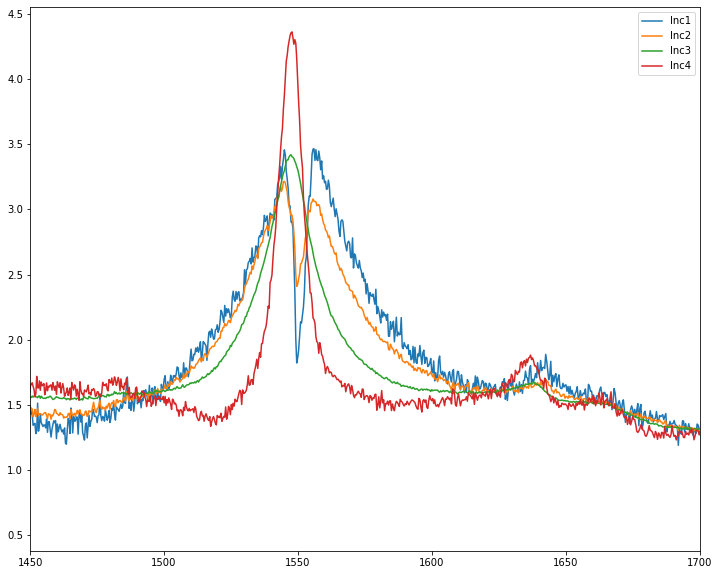

In [356]:
plot_latent(predict1, reverse=False)
plot_latent(predict1, reverse=False, CIVonly=True)

#### Param2

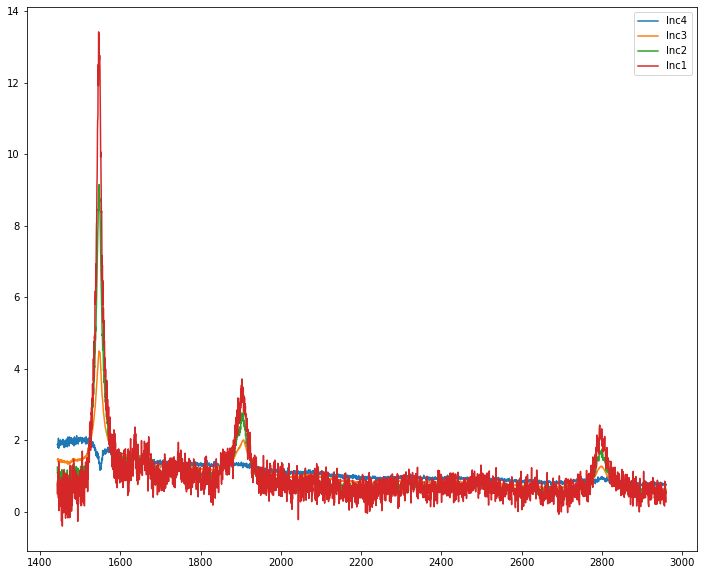

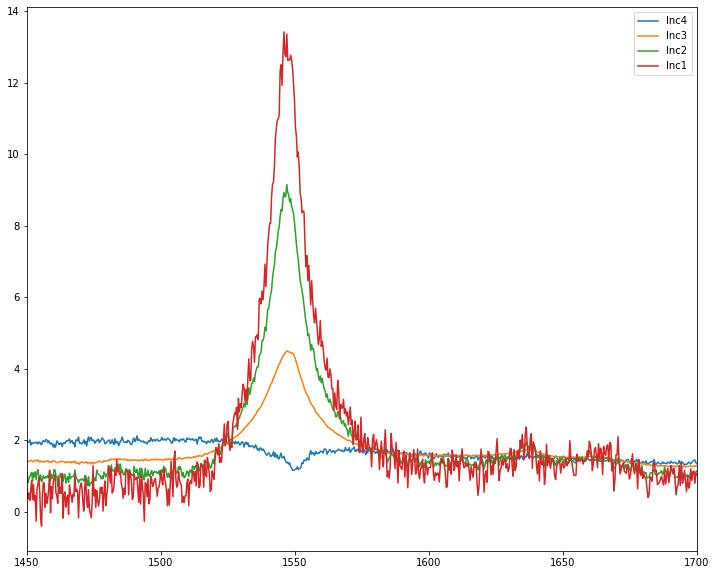

In [357]:
plot_latent(predict2)
plot_latent(predict2, reverse=True, CIVonly=True)

#### Param3

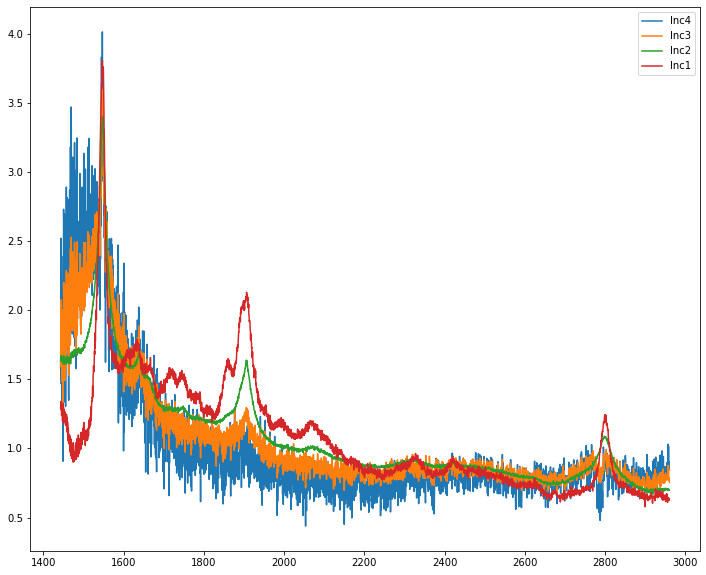

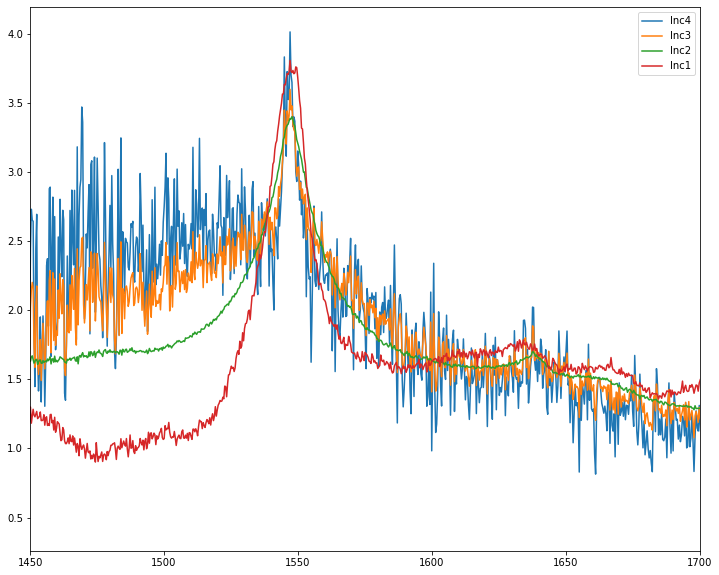

In [358]:
plot_latent(predict3, reverse=True)
plot_latent(predict3, reverse=True, CIVonly=True)


#### Param4

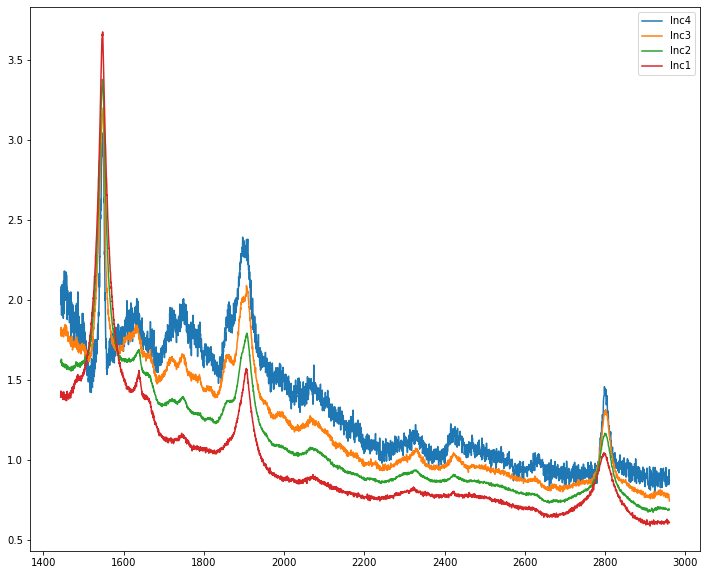

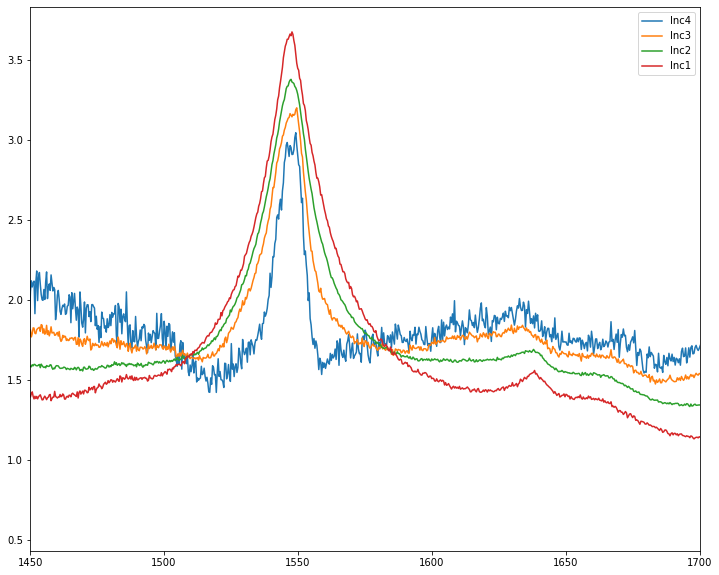

In [359]:
plot_latent(predict4, reverse=True)
plot_latent(predict4, reverse=True, CIVonly=True)


#### Param5

#### Param6

Do PCA

In [306]:
from sklearn.decomposition import PCA
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler

In [307]:
pipe = Pipeline([('scaler', StandardScaler()), #normalizing data
                ('reducer', PCA())])           #dimensionality reduction

model = PCA()

pc = pipe.fit_transform(X_compressed)          #data goes here for processing


#Extracting useful metrics
var = pipe.steps[1][1].explained_variance_ratio_
var_sum = pipe.steps[1][1].explained_variance_ratio_.cumsum()

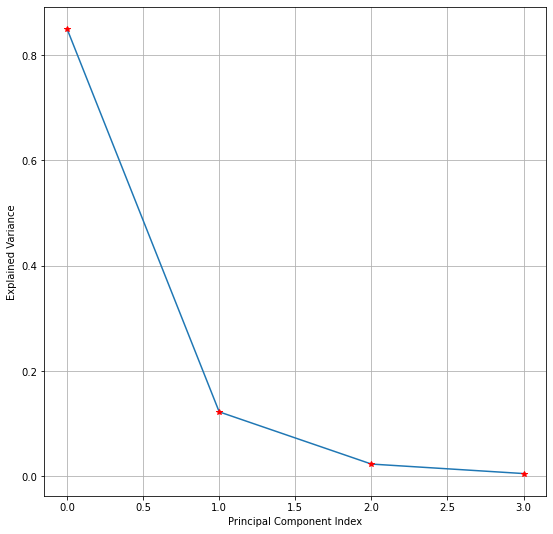

In [308]:
fig = plt.figure(figsize=(9,9))
plt.plot(var)
plt.plot(var,'r*')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

Did PCA order the features for me??  Maybe don't want this.

In [309]:
pc.shape

(22898, 4)

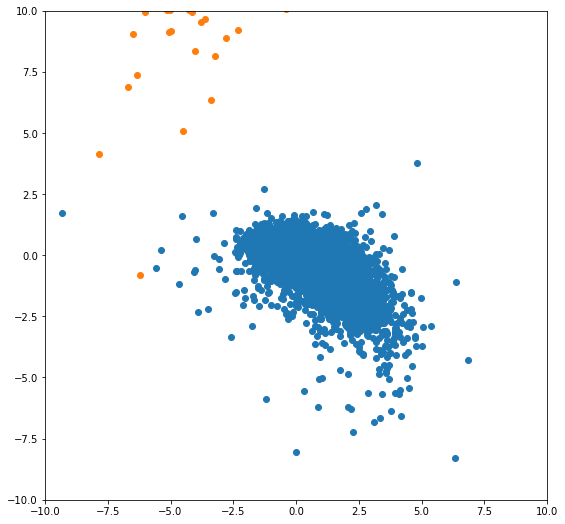

In [310]:
fig = plt.figure(figsize=(9,9))
plt.scatter(pc[:,0], pc[:,1])
plt.scatter(X_compressed[:,0], X_compressed[:,3])
plt.ylim(-10,10)
plt.xlim(-10,10)
plt.show()

In [311]:
pd.DataFrame(pc)

0         1         2         3
0     -0.297441  0.092877 -0.153250  0.008515
1      0.463765 -0.322678 -0.214201 -0.017838
2      0.211892  0.144474  0.170079 -0.009017
3     -0.715045  0.015943 -0.181135  0.060971
4     -0.116006 -0.113063 -0.117870  0.027508
...         ...       ...       ...       ...
22893 -0.404989  0.279041  0.124568  0.036600
22894 -0.294768  0.206976 -0.080259  0.001875
22895  0.234716  0.406627 -0.052704 -0.083473
22896  0.950968  0.549387  0.492172 -0.107256
22897 -0.047762  0.256742 -0.119133 -0.040221

[22898 rows x 4 columns]

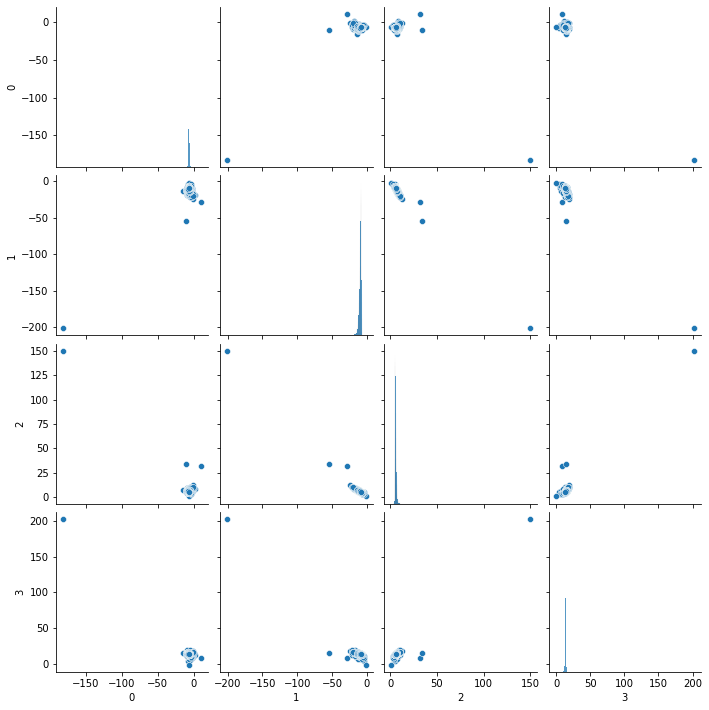

In [312]:
import seaborn
df = pd.DataFrame(X_compressed)
seaborn.pairplot(df)

---

Compute CIV EW and blueshift

In [112]:
X

array([[ 1.342783  ,  0.9539223 ,  0.9956144 , ...,  0.7161331 ,
         0.7169757 ,  0.6376466 ],
       [ 1.5499767 ,  2.0769315 ,  1.7400922 , ...,  0.80960095,
         0.79215384,  0.7184477 ],
       [ 1.8556942 ,  1.590189  ,  1.754602  , ..., -0.08566077,
         0.14366394,  0.34498736],
       ...,
       [ 2.3988113 ,  2.0789554 ,  1.6517277 , ...,  0.53374416,
         0.6951343 ,  0.65663505],
       [ 3.6431258 ,  3.4722507 , -0.6894375 , ...,  0.85629445,
         0.95487314,  0.6408582 ],
       [ 1.8150324 ,  1.609536  ,  1.5669562 , ...,  0.8462349 ,
         0.64517903,  0.5358659 ]], dtype=float32)

In [198]:
def get_CIV(wave, flux, reconstruction, name, waverange=[1500,1600]):
    #Going to save plots, but not show with magic above
    
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(wave, flux)
    ax.plot(wave, reconstruction, label="Autoencoder Reconstruction")
    ax.plot([1549.48,1549.48], [0.2*max(reconstruction), max(reconstruction)+2], "--k", label="Laboratory Wavelength - CIV")
    
    
    #Fit continuum
    cont1 = ((wave>=1445)&(wave<=1465))
    cont2 = ((wave>=1700)&(wave<=1705))
    ax.axvspan(1445, 1465, alpha=0.5, color='grey')
    ax.axvspan(1700, 1705, alpha=0.5, color='grey')

    m,b = np.polyfit(np.concatenate((wave[cont1], wave[cont2])), np.concatenate((reconstruction[cont1], reconstruction[cont2])), 1)
    continuum = wave*m + b
    ax.plot(wave, continuum, "-r", label="Power-law Continuum")
    
    #Plot EW region under reconstruction
    EW = ((wave>=waverange[0])&(wave<=waverange[1]))
    ax.fill_between(wave[EW], continuum[EW], reconstruction[EW], color="blue", alpha=0.2)

    #And compute the EW
    CIV_EW = 0
    ew_list = [0.]
    for i in range(len(wave[EW])):
        try:
            CIV_EW += max(( (reconstruction[EW][i] - continuum[i]) / continuum[i] ) * ( wave[EW][i+1] - wave[EW][i] ), 0) #no absorption
        except IndexError:
            CIV_EW += max(( (reconstruction[EW][i] - continuum[i]) / continuum[i] ) * ( wave[EW][i] - wave[EW][i-1] ), 0)

        ew_list.append(CIV_EW)


    ind_half_flux = abs((CIV_EW / 2) - np.array(ew_list)).argmin()
    CIV_blue = blueshift(wave[EW][ind_half_flux])
        
    ax.plot([wave[EW][ind_half_flux],wave[EW][ind_half_flux]], [0.2*max(reconstruction), max(reconstruction)+2], "--b", label="Observed Wavelength - Blue = %.2f km/s, EW = %.2f Å" % (CIV_blue, CIV_EW))

    ax.set_xlim(1435, 1710)
    ax.set_ylim(0.2*max(reconstruction), max(reconstruction)+2)
    
    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig("/Users/Trevor1/Desktop/data/spectra/VLA_8403col_1.6z2.2/pngs_CIV_test/{}.png".format(name))
    plt.show()
        
    return CIV_blue, CIV_EW

In [199]:
%%capture
reconstructions = stacked_ae.predict(X)
print("done reconstructions")

NN=0
blue_list = []
ew_list   = []

for i in range(len(X)):
    civ_blue, civ_ew = get_CIV(wave[i], X[i], reconstructions[i], names[i])
    if civ_blue > 1000:
        civ_blue, civ_ew = get_CIV(wave[i], X[i], reconstructions[i], names[i], waverange=[1465,1600])
    blue_list.append(civ_blue)
    ew_list.append(civ_ew)
    
    if i%10000==0: print(i)
    NN+=1
    if NN>500: 
        print("done")
        break

In [200]:
blue_list = np.array(blue_list)
ew_list   = np.array(ew_list)

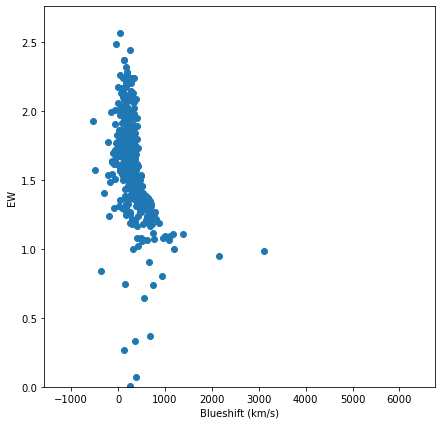

In [201]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(blue_list, np.log10(ew_list))
#ax.scatter(blue_list, ew_list)
#ax.set_xlim(-500,5000)
ax.set_xlabel("Blueshift (km/s)")
ax.set_ylabel("EW")
#ax.set_yscale("log")
ax.set_xlim(-1577.0575829238915, 6752.935855052574)
ax.set_ylim(0.0, 2.762242337463174)
plt.show()

In [265]:
len(blue_list)

8368

In [268]:
len(dat.iloc[found])

8368

In [269]:
found

array([   0,    1,    2, ..., 8397, 8398, 8399])

In [275]:
np.array([np.array(dat.iloc[found]["name"])[np.array(blue_list)<-4000], np.array(blue_list)[np.array(blue_list)<-4000]]).T

array([['172858.16+603512.7', -5649.691184199695],
       ['135050.37+662910.6', -9231.230749590182],
       ['102214.76+021428.7', -6327.456050779935],
       ['103607.52+015659.0', -6625.699062649241],
       ['105704.19+030108.1', -6304.6724495879225],
       ['140821.66+025733.3', -6507.385050650054],
       ['142923.91+024023.1', -8373.040559877343],
       ['141927.49+044513.7', -5342.088933666452],
       ['150935.96+574300.5', -8648.570873877847],
       ['001741.87-105613.2', -6713.051956846002],
       ['003414.20-092738.7', -7179.950340194772],
       ['075551.44+352549.7', -7324.262237371567],
       ['152307.34+535358.2', -7909.309191632027],
       ['162501.98+430931.6', -8186.824798682457],
       ['090809.13+444138.8', -8118.804877281406],
       ['075331.84+270415.3', -5471.629305174152],
       ['103628.19+501157.8', -6033.44360386226],
       ['093217.06+415312.0', -8659.537254534582],
       ['103808.93+464249.2', -7137.9519384124],
       ['115757.24+505442.4', -59

Cell above never ended even though all the plots were done??  Fix this so I can actually save EW+blueshift!

In [496]:
CIV_data = np.array([blue_list, ew_list]).T
CIV_df   = pd.DataFrame(X_compressed, columns=["CIV_Blueshift_AE", "CIV_EW_AE"])
CIV_df.head()

(8368, 6)

---

Save a file with the latent parameters and reconstructions.

In [118]:
latent_params = pd.DataFrame(X_compressed, columns=["Latent{}".format(i) for i in range(1,5)])
latent_params.head()

Latent1   Latent2    Latent3    Latent4
0 -11.352660 -3.301174 -17.828890  17.440033
1 -10.004896 -4.361762 -17.439102  16.528103
2 -12.125273 -3.403300 -18.227619  18.858738
3 -11.002450 -2.297429 -17.803780  17.630707
4 -10.392772 -3.270949 -17.595032  17.046179

In [121]:
valid

array([ True,  True,  True, ...,  True,  True,  True])

In [123]:
sample_cut = dat.iloc[found][valid]
sample_cut.shape

(91962, 97)

In [124]:
df = pd.merge(sample_cut, latent_params, right_index=True, left_index=True)
df.head()

Unnamed: 0              SDSS_NAME        RA        DEC   THING_ID  PLATE  \
0          10  b'000001.56+203011.5'  0.006523  20.503197  290594773   7596   
1          19  b'000002.15+151516.6'  0.008980  15.254639  246765254   6172   
2          20  b'000002.19-021947.2'  0.009139  -2.329783   59825899   7850   
3          26  b'000002.97+225645.9'  0.012415  22.946096  311303506   7665   
4          28  b'000003.18+050822.3'  0.013254   5.139552  155964498   8740   

     MJD  FIBERID  SPECTRO         Z  ...         KFLUX     KFLUX_ERR  \
0  56945      821  b'BOSS'  2.083215  ...  0.000000e+00  0.000000e+00   
1  56269      394  b'BOSS'  1.710000  ...  1.538285e-31  6.478741e-32   
2  56956      339  b'BOSS'  1.966623  ...  0.000000e+00  0.000000e+00   
3  57328      452  b'BOSS'  1.759105  ...  0.000000e+00  0.000000e+00   
4  57367      340  b'BOSS'  1.801677  ...  2.371781e-31  5.186590e-32   

   FIRST_MATCHED  FIRST_FLUX  FIRST_SNR  SDSS2FIRST_SEP    Latent1   Latent2  \
0             -1        -1.0       -1.0            -1.0 -11.352660 -3.301174   
1             -1        -1.0       -1.0            -1.0 -10.004896 -4.361762   
2              0        -1.0       -1.0            -1.0 -12.125273 -3.403300   
3             -1        -1.0       -1.0            -1.0 -11.002450 -2.297429   
4              0        -1.0       -1.0            -1.0 -10.392772 -3.270949   

     Latent3    Latent4  
0 -17.828890  17.440033  
1 -17.439102  16.528103  
2 -18.227619  18.858738  
3 -17.803780  17.630707  
4 -17.595032  17.046179  

[5 rows x 101 columns]

In [125]:
! ls /Users/Trevor1/Desktop/data/files/catalogs/

DR14Q_v4_4.fits                        Rankine20_CIV_HeII_wDelGI.fits
DR16Q_v4.fits                          Rankine20_CIV_HeII_wDelGI_wCIVDist.csv
DR16Q_v4.short.csv.wrelgi              dr7_bh_May09_2011.fits
Rankine20_CIV_HeII.fits


In [126]:
df.to_csv("/Users/Trevor1/Desktop/data/files/catalogs/dr14_4latentparams.csv")